In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.special import gamma, gammainc
import h5py
from scipy.optimize import curve_fit

# 1) Feed PEDM correct doppler shifts from ADCP East current 

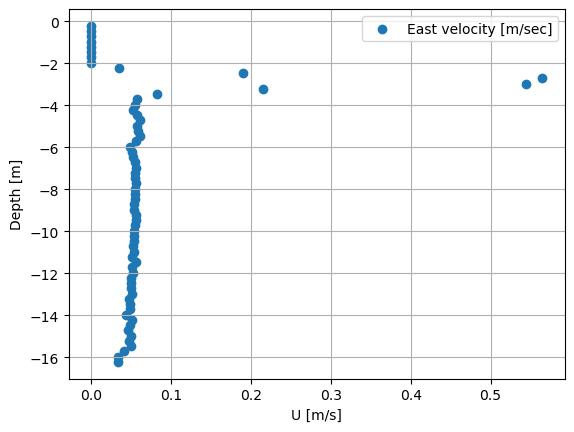

In [64]:
hf = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\ADCP_19_01_22_04.mat', 'r')
east_vel = np.array(hf['East_vel'])
north_vel = np.array(hf['North_vel'])
vertical_vel = np.array(hf['Vertical_vel'])
z_adcp = np.array(hf['z_vec'])
t = hf['time_vec']
hf.close()

time_start = 0*60 # sec
time_stop = 15*60 # sec
time_step = 1 #sec
start_i = int(time_start/time_step)
stop_i = int(time_stop/time_step)

east_vel_mean = np.mean(east_vel[start_i:stop_i], axis=0)
north_vel_mean = np.mean(north_vel[start_i:stop_i], axis=0)
vertical_vel_mean = np.mean(vertical_vel[start_i:stop_i], axis=0)

fig, ax = plt.subplots()
ax.scatter(east_vel_mean, z_adcp, label='East velocity [m/sec]')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
indexes = np.array([5, 10, 20, 30, 40, 50, 51, 52, 53, 54])

In [66]:
correct_edm_U = east_vel_mean[indexes]
correct_edm_z = z_adcp[indexes].flatten()

Text(0.5, 0, 'U velocity')

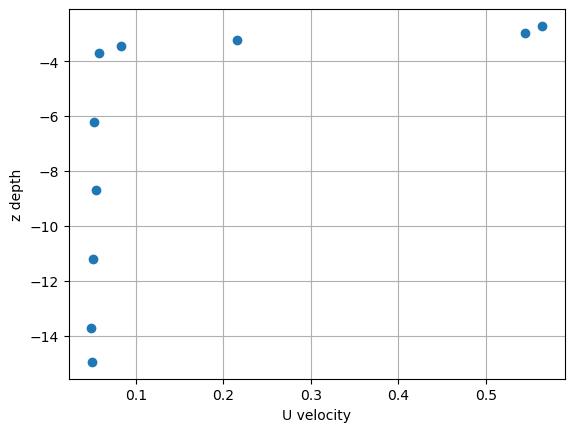

In [67]:
plt.scatter(correct_edm_U, correct_edm_z)

plt.grid(True)
plt.ylabel("z depth")
plt.xlabel("U velocity")

In [50]:
c_dop = correct_edm_U

# find k using z = - 1 / 2k
wave_no = - 1/ ( 2 * correct_edm_z )

In [51]:
wave_no

array([0.03341897, 0.03646558, 0.04459682, 0.05739499, 0.08049505,
       0.13471418, 0.14444347, 0.15568749, 0.16882984, 0.18439557])

# 1.1) Correct Doppler Shifts

(0.0, 0.6)

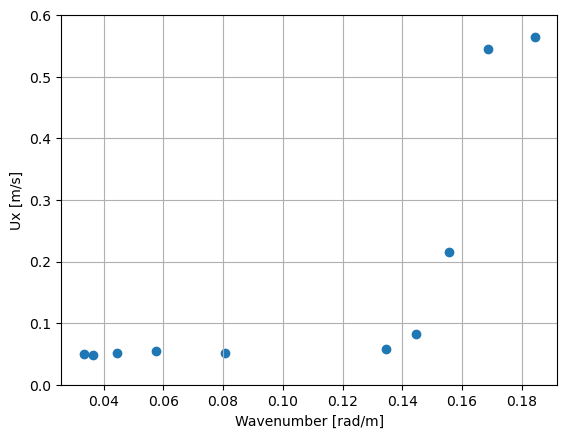

In [56]:
plt.scatter(wave_no, c_dop)

plt.grid(True)
plt.ylabel("Ux [m/s]")
plt.xlabel("Wavenumber [rad/m]")

plt.ylim(0, 0.6)

## 1.2) Feed Correct Values into PEDM 

In [76]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=16):

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1

                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

In [77]:
pPEDM_1, pEDM_1, eps_PEDM_1, eps_EDM_1, verbose_1 = pedm(wave_no, c_dop)

In [78]:
z = np.linspace(-16, 0, 100)
U_1_fun = lambda z: np.polyval(pPEDM_1, z)

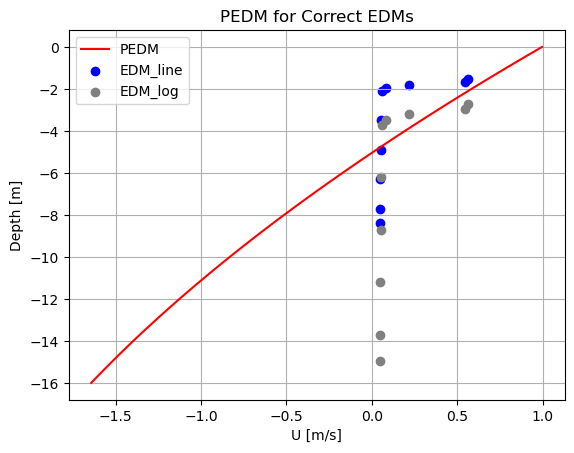

In [79]:
plt.plot(U_1_fun(z), z, label="PEDM", color = 'red')

plt.scatter( c_dop, -1/(3.56*wave_no), label='EDM_line', color = 'blue')
plt.scatter( c_dop, -1/(2*wave_no), label='EDM_log', color = 'grey')

plt.grid(True)
plt.title("PEDM for Correct EDMs")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

(-20.0, 0.0)

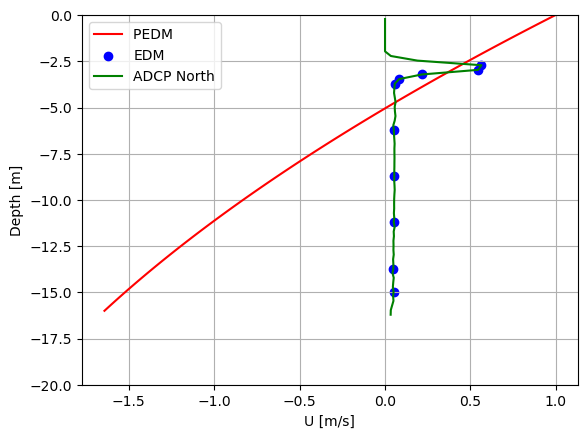

In [80]:
plt.plot(U_1_fun(z), z, label="PEDM ", color = 'red')
plt.scatter( c_dop, -1/(2*wave_no), label='EDM', color = 'blue')

plt.plot(east_vel_mean, z_adcp, label='ADCP North', color = 'green')

plt.grid(True)
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

plt.ylim(-20,0)

## 1.3) Test PEDM 

In [152]:
k_vect = wave_no
c_til = c_dop

waterDepth = 16

Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

np.tanh(np.abs(waterDepth) * k_vect)

array([0.48896828, 0.52516787, 0.61289757, 0.7251016 , 0.85858103,
       0.97351136, 0.98052896, 0.98637283, 0.9910303 , 0.99453966])

In [153]:
nm = min(12, round(len(k_vect) / 2))
nMax_vals = np.arange(0, nm+1)
    
depthRange = np.abs(Z_eff[0] - Z_eff[-1])
deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

depthRange = np.abs(Z_eff[0] - Z_eff[-1])
deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

In [154]:
nMax_vals

array([0, 1, 2, 3, 4, 5])

In [155]:
deltaz_T_vals

array([0.04618973, 0.09237947, 0.1385692 , 0.18475893, 0.23094867,
       0.2771384 , 0.32332814, 0.36951787, 0.4157076 , 0.46189734,
       0.50808707, 0.5542768 , 0.60046654, 0.64665627, 0.692846  ,
       0.73903574, 0.78522547, 0.83141521, 0.87760494, 0.92379467])

In [156]:
deltaz_B_vals

array([0.09237947, 0.28200048, 0.47162149, 0.6612425 , 0.85086351,
       1.04048453, 1.23010554, 1.41972655, 1.60934756, 1.79896857,
       1.98858958, 2.1782106 , 2.36783161, 2.55745262, 2.74707363,
       2.93669464, 3.12631566, 3.31593667, 3.50555768, 3.69517869])

In [157]:
z_c = max(4* np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

z_c

-16

In [158]:
# We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
eps_PEDM_out = np.inf
eps_EDM_out = np.inf

pPEDM_out = np.nan
pEDM_out = np.nan

verbose = []
combo = 0

In [159]:
Z_eff.shape, c_til.shape

((10,), (10,))

### 1.3.1) Step 1

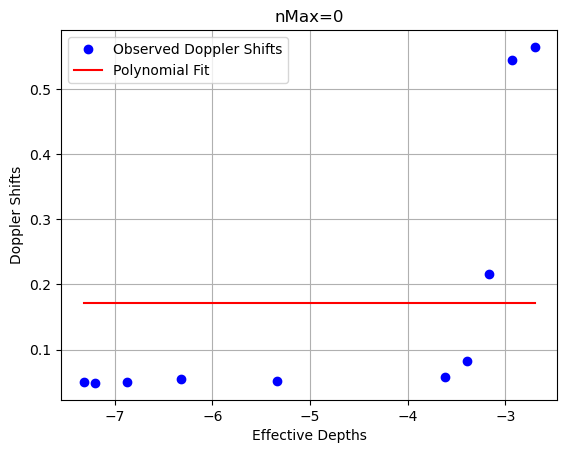

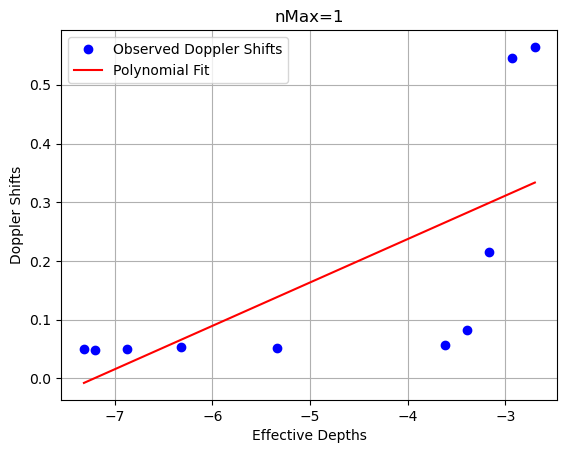

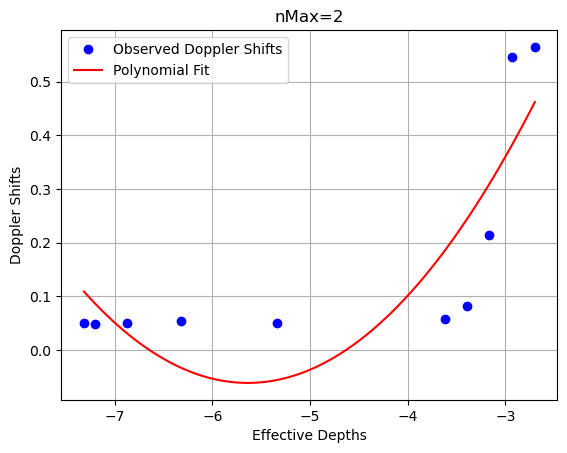

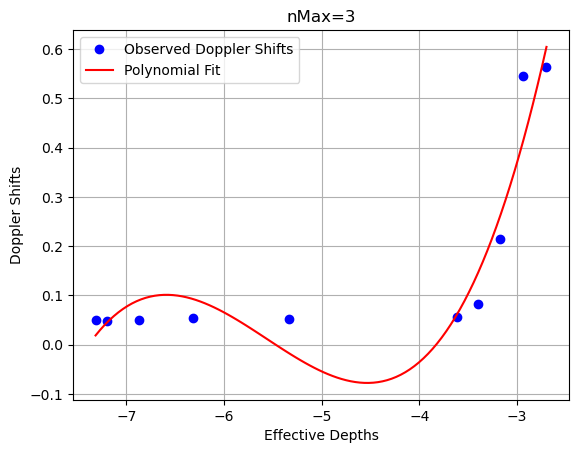

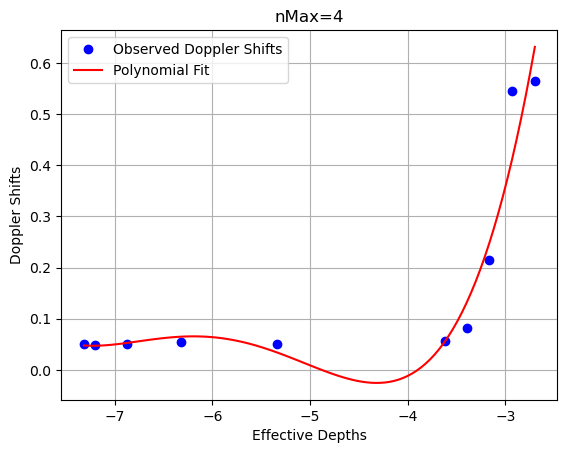

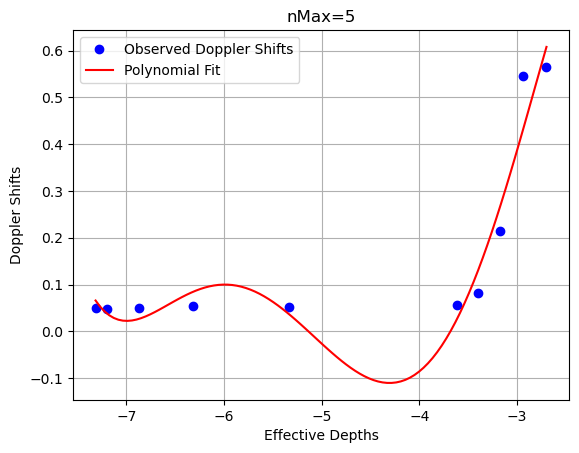

In [160]:
import matplotlib.pyplot as plt

for nMax in nMax_vals:
    # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # Generate points for the polynomial curve
    x_fit = np.linspace(Z_eff.min(), Z_eff.max(), 100)
    J_fit = np.polyval(p1, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(Z_eff, c_til, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_fit, J_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax}')
    plt.legend()
    plt.show()  # Show the plot for this combination


### 1.3.2) Step 2 and 3

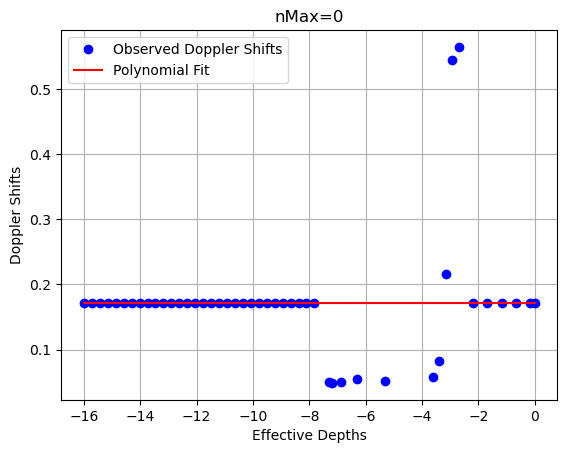

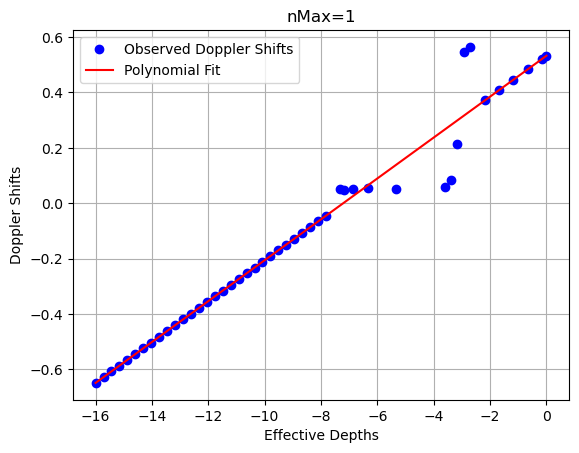

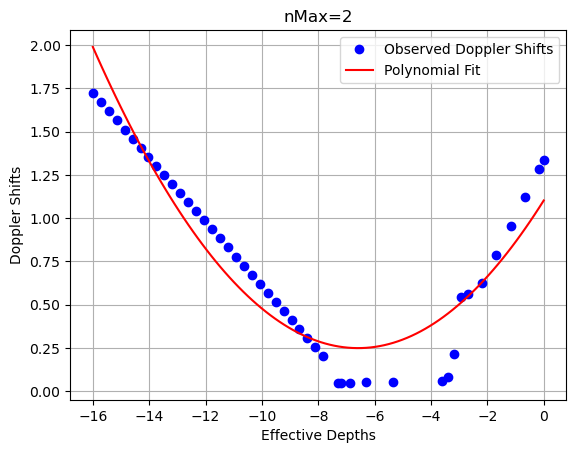

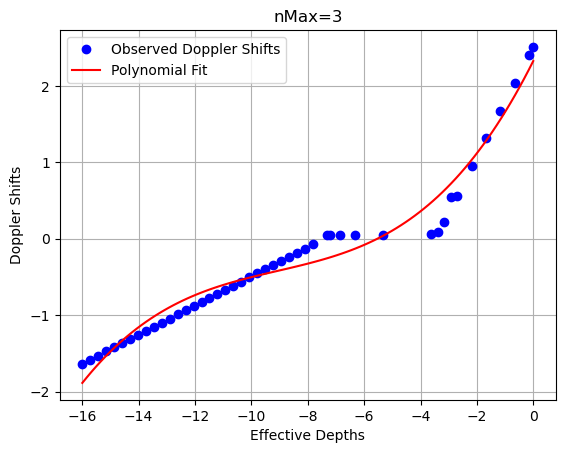

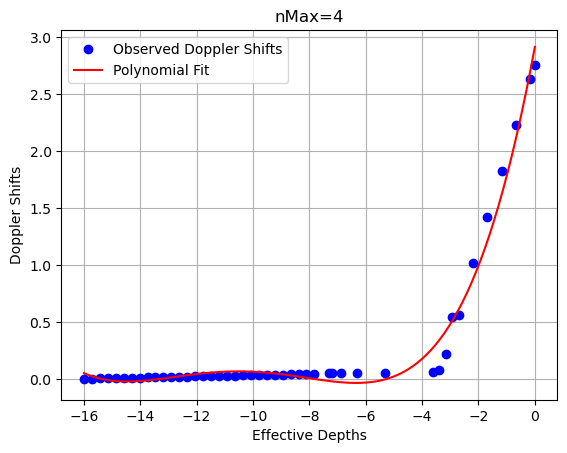

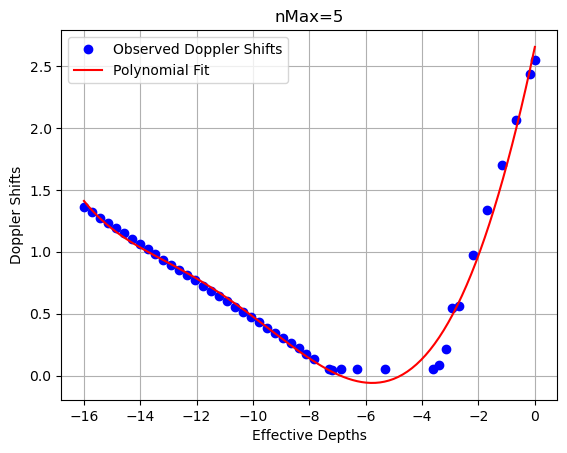

In [161]:
for nMax in nMax_vals:
    i = 1
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)

    # Generate points for the polynomial curve
    x_fit = np.linspace(zEx.min(), zEx.max(), 100)
    J_fit = np.polyval(pEDM, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(zEx, cTilEx, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_fit, J_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax}')
    plt.legend()
    plt.show()  # Show the plot for this combination

### 1.3.3) Monotomic Check 

In [162]:
for nMax in nMax_vals:
    i = 1
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)
    '''
    # Generate points for the polynomial curve
    x_fit = np.linspace(zEx.min(), zEx.max(), 100)
    J_fit = np.polyval(pEDM, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(zEx, cTilEx, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_fit, J_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax}')
    plt.legend()
    plt.show()  # Show the plot for this combination
    '''

    # Determine if profile is monotonic with range of mapped depths.
    nv = np.arange(nMax, 0, -1)
    pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
    rts = np.roots(pczEx_p)  # Find roots
    rts = rts[np.isreal(rts)]  # Discard complex roots

    # If there roots of the derivative within ranges of mapped depths, don't go further.
    if np.any((rts > Z_eff[0]) & (rts < 0)):
        print(f"nMax = {nMax}: Loops continues")

    else:
        print(f"nMax = {nMax}: STOPS - not MONOTONIC")

nMax = 0: STOPS - not MONOTONIC
nMax = 1: STOPS - not MONOTONIC
nMax = 2: Loops continues
nMax = 3: STOPS - not MONOTONIC
nMax = 4: Loops continues
nMax = 5: Loops continues


### 1.3.4) Steps 4, 5 and 6

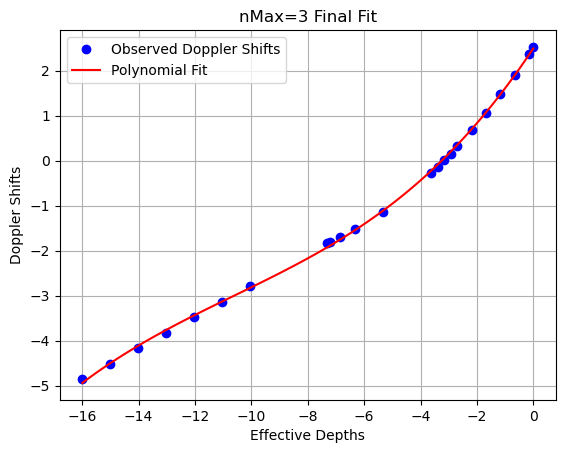

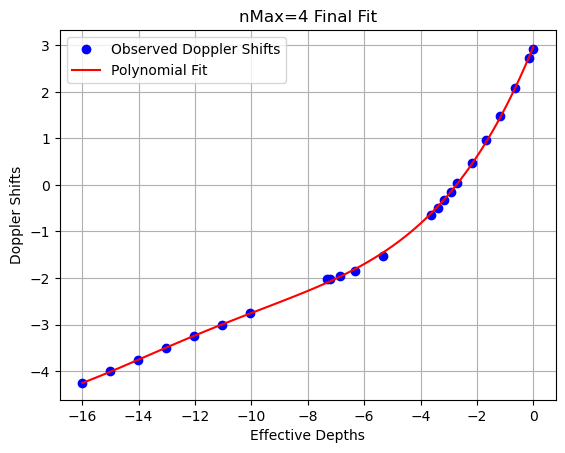

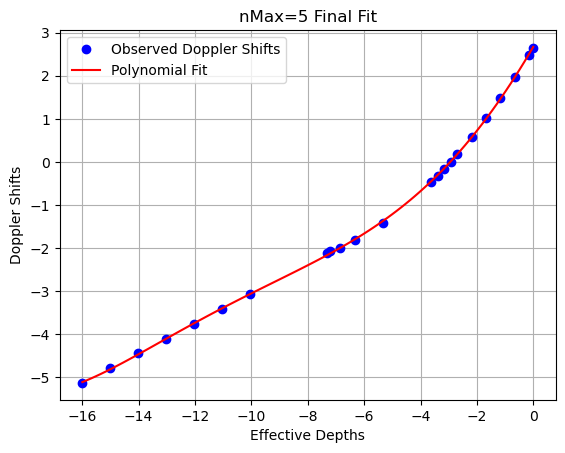

In [170]:
for nMax in nMax_vals:
    i = 10
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)

    # Determine if profile is monotonic with range of mapped depths.
    nv = np.arange(nMax, 0, -1)
    pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
    rts = np.roots(pczEx_p)  # Find roots
    rts = rts[np.isreal(rts)]  # Discard complex roots

    # If there roots of the derivative within ranges of mapped depths, don't go further.
    if not np.any((rts > Z_eff[0]) & (rts < 0)):
        continue

    # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
    pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

    # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
    zB2 = np.linspace(0, deltaz_B_vals[i]/2, 100)
    pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

    depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i]/2)

    zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
    Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

    # STEP 6: Perform a final polynomial fit on the expanded set of points.
    pPEDM = np.polyfit(zEx2, Uvals, nMax)

    # Generate points for the polynomial curve
    x_last_fit = np.linspace(zEx.min(), zEx.max(), 100)
    F_last_fit = np.polyval(pPEDM, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(zEx2, Uvals, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_last_fit, F_last_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax} Final Fit')
    plt.legend()
    plt.show()  # Show the plot for this combination


    

#### get rid of step 5 and replace with previous points

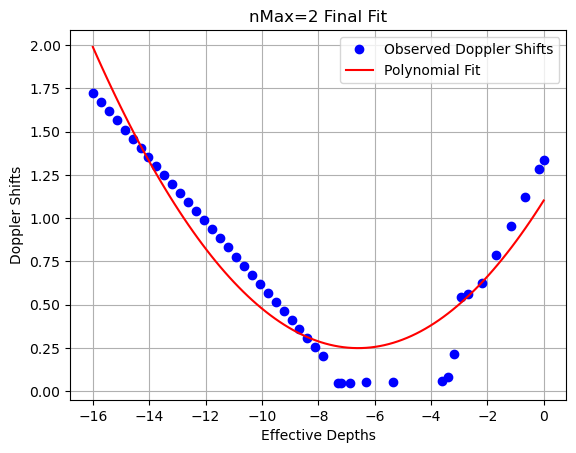

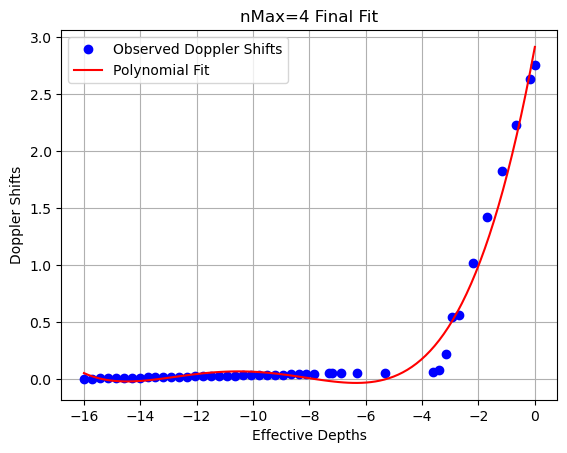

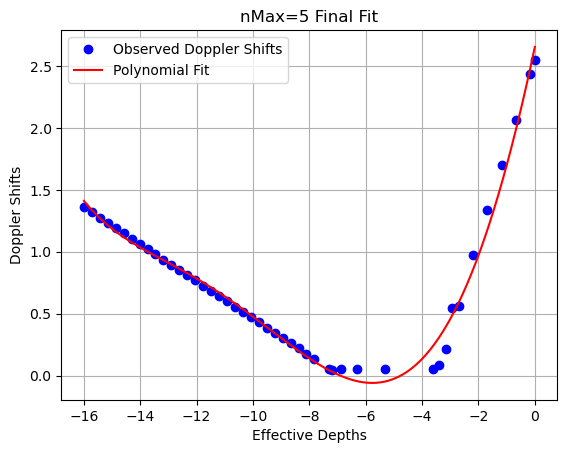

In [210]:
for nMax in nMax_vals:
    i = 1
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)

    # Determine if profile is monotonic with range of mapped depths.
    nv = np.arange(nMax, 0, -1)
    pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
    rts = np.roots(pczEx_p)  # Find roots
    rts = rts[np.isreal(rts)]  # Discard complex roots

    # If there roots of the derivative within ranges of mapped depths, don't go further.
    if not np.any((rts > Z_eff[0]) & (rts < 0)):
        continue

    # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
    pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

    # STEP 5: Replaced
    zEx2 = zEx
    Uvals = cTilEx

    # STEP 6: Perform a final polynomial fit on the expanded set of points.
    pPEDM = np.polyfit(zEx2, Uvals, nMax)

    # Generate points for the polynomial curve
    x_last_fit = np.linspace(zEx.min(), zEx.max(), 100)
    F_last_fit = np.polyval(pPEDM, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(zEx2, Uvals, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_last_fit, F_last_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax} Final Fit')
    plt.legend()
    plt.show()  # Show the plot for this combination


    

### 1.3.5) Find Doppler Shifts and Minimise RMS

In [211]:
eps_EDM_output = []
eps_PEDM_output = []

array_PEDM = []
array_EDM = []

for nMax in nMax_vals:
    i = 5
    j = 5
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)

    # Determine if profile is monotonic with range of mapped depths.
    nv = np.arange(nMax, 0, -1)
    pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
    rts = np.roots(pczEx_p)  # Find roots
    rts = rts[np.isreal(rts)]  # Discard complex roots

    # If there roots of the derivative within ranges of mapped depths, don't go further.
    if not np.any((rts > Z_eff[0]) & (rts < 0)):
        continue

    # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
    pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

    '''
    # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
    zB2 = np.linspace(0, deltaz_B_vals[i]/2, 100)
    pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

    depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i]/2)

    zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
    Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))
    '''
    # STEP 5: Replaced
    zEx2 = zEx
    Uvals = cTilEx

    # STEP 6: Perform a final polynomial fit on the expanded set of points.
    pPEDM = np.polyfit(zEx2, Uvals, nMax)
    
    c_tilEDM = 0
    c_tilPEDM = 0

    if nMax < 2:
        for n in range(nMax + 1):
            c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
            c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
    else:
        for n in range(nMax + 1):
            c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
            c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

    # Calculate RMS differences (equation (9) in manuscript)
    eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
    eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

    eps_EDM_output.append(eps_EDM)
    eps_PEDM_output.append(eps_PEDM)

    array_PEDM.append(pPEDM)
    array_EDM.append(pEDM)
    
    #print(eps_EDM)
    #print(eps_PEDM)

    

In [212]:
arg_EDM = np.argmin(eps_EDM_output)
arg_PEDM = np.argmin(eps_PEDM_output)

In [213]:
arg_EDM, arg_PEDM

(1, 1)

In [214]:
pEDM_1 = array_EDM[arg_EDM]
pPEDM_1 = array_PEDM[arg_PEDM]

In [215]:
z = np.linspace(-20, 0, 100)
U_1_fun = lambda z: np.polyval(pPEDM_1, z)
U_2_fun = lambda z: np.polyval(pEDM_1, z)

(-16.0, 0.1)

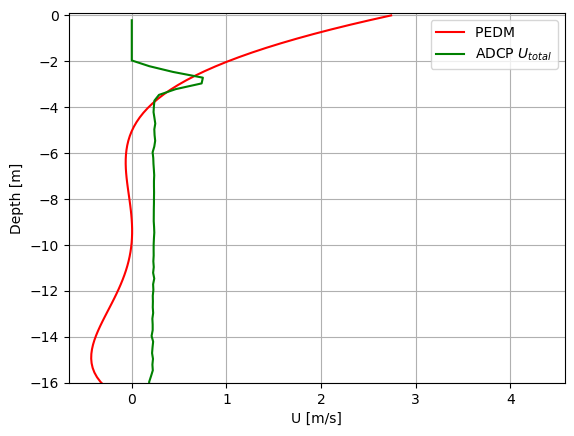

In [220]:
plt.plot(U_1_fun(z), z, label="PEDM ", color = 'red')
#plt.scatter( y_fit[1:],-1/(2*wavenumbers), label='EDM', color = 'blue')

U = np.sqrt(east_vel_mean)
plt.plot(U, z_adcp, label='ADCP $U_{total}$', color = 'green')

plt.grid(True)
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
plt.ylim(-16,0.1)
#plt.xlim(0,1)